# Google Speech Commands Dataset Generator 


In [4]:
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import re
from tqdm import trange
import copy
import tarfile
import soundfile as sf

In [5]:
# get a directory to download and encode dataset files

directory = os.path.expanduser("~/data")

In [6]:
os.chdir(directory)

# create new directory for raw HD
assert os.path.isdir("rawSC") == True

os.chdir("rawSC")

In [7]:
if not os.path.exists("speech_commands_v0.02.tar.gz"):
    !wget http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

In [8]:
# unzip to folder
if not os.path.isdir("speech_commands_extracted"):
    # downloading the 35 classes version
    file = tarfile.open("speech_commands_v0.02.tar.gz")

    file.extractall("./speech_commands_extracted")

    file.close()

In [9]:
os.chdir("speech_commands_extracted")
print("current cwd", os.getcwd())

current cwd /its/home/ts468/data/rawSC/speech_commands_extracted


In [10]:
# load GSC validation and training data list

# load a list of training audio files
validation_files = []
with open("validation_list.txt", "r") as file:
    for line in file:
        x = line[:-1]
        validation_files.append(x)
        
# load a list of testing audio files
test_files = []
with open("testing_list.txt", "r") as file:
    for line in file:
        x = line[:-1]
        test_files.append(x)

In [11]:
# View sound file
print("file format: ", test_files[0])
ipd.Audio(test_files[0])

file format:  right/bb05582b_nohash_3.wav


In [12]:
# load classes and assign labels

folders = os.listdir()
exception = ["validation_list.txt",
             "_background_noise_",
             ".DS_Store",
             "README.md",
             "LICENSE",
             "testing_list.txt"]

assert len(list(set(folders) - set(exception))) == 35

classes = np.sort(list(set(folders) - set(exception)))

classes_and_labels = {}

for i, c in enumerate(classes):
    classes_and_labels[c] = i

In [13]:
def to_mel_spectrogram(file_name, display = False):
    
    audio, sr = librosa.load(file_name, sr = 20510, mono=True)
    
    # Apply pre-emphasis filter
    pre_emphasis = 0.95
    emphasized_audio = np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])

    # Define frame length and stride in samples
    frame_length = int(sr * 0.025)  # 25ms
    hop_length = int(sr * 0.01)  # 10ms

    # Compute the power spectrum using a 512-point FFT
    fft_size = 512 
    power_spectrum = np.abs(librosa.stft(emphasized_audio, n_fft=fft_size, hop_length=hop_length, win_length=frame_length))**2

    # Compute the filter banks with 40 triangular filters
    num_bands = 80
    filter_banks = librosa.filters.mel(n_fft = fft_size, sr = sr, n_mels=num_bands)

    # Apply the filter banks to the power spectrum
    mel_spec = np.dot(filter_banks, power_spectrum)

    # Crop or pad to 80 steps by repeating the last frame
    target_steps = 100
    current_steps = mel_spec.shape[1]
    if current_steps < target_steps:
        padding = np.tile(mel_spec[:, -1:], (1, target_steps - current_steps))
        mel_spec = np.hstack((mel_spec, padding))
    elif current_steps > target_steps:
        mel_spec = mel_spec[:, :target_steps]

    # Convert power spectrogram to dB scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    if display:
        # Display the filter banks with the 'viridis' colormap
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr, cmap='viridis')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel Filter Banks with Pre-Emphasis Filter (Cropped/Padded to 80 Steps)')
        plt.tight_layout()
        plt.show()
        
        print(mel_spec_db.shape)
    
    else:
        return mel_spec_db

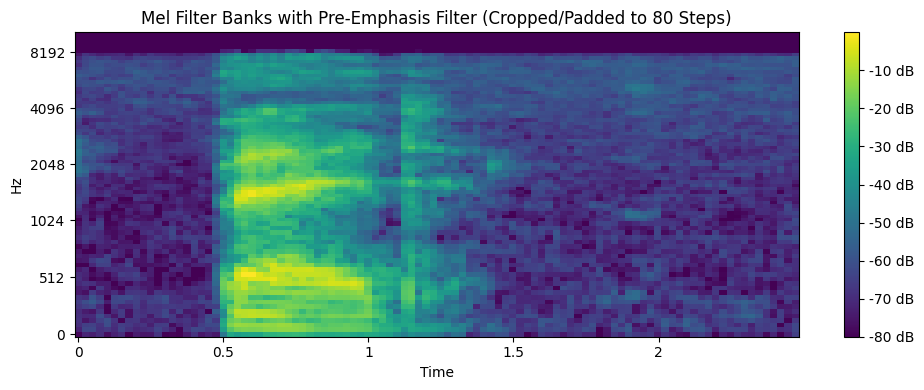

(80, 100)
1578


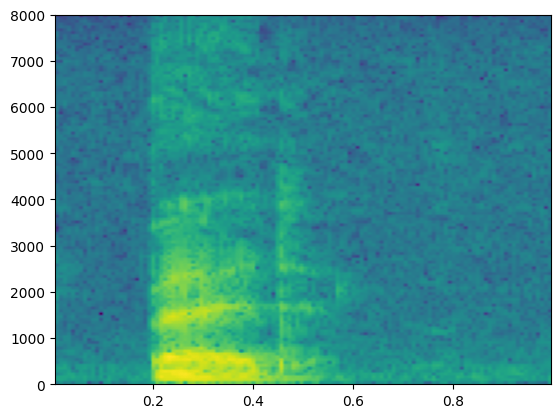

(16000,)


In [14]:
# Visualise the output of the mel encoding
rnd_val = 1578#np.random.randint(0, len(test_files))
test_image = test_files[rnd_val]
to_mel_spectrogram(test_image, True)
print(rnd_val)
# Visualise the same input but on soecgram (visual check)
data, samplerate = sf.read(test_image)  
Pxx, freqs, bins, im = plt.specgram(data, Fs=samplerate)
plt.show()
print(data.shape)

In [15]:
# Get all files to loop through

all_files = []

for folder in list(set(folders) - set(exception)):
    files_in_folder = os.listdir(folder)
    for sound_file in files_in_folder:
        all_files.append(folder + "/" + sound_file)

In [16]:
training_x_data = []
training_y_data = []
testing_x_data = []
testing_y_data = []
validation_x_data = []
validation_y_data = []

# save all to a list
for i in trange(len(all_files)):
    
    if all_files[i] in validation_files:
        validation_x_data.append(copy.deepcopy(to_mel_spectrogram(all_files[i])))
        validation_y_data.append(int(classes_and_labels[re.split("[/]", all_files[i])[0]]))

    if all_files[i] in test_files:
        testing_x_data.append(copy.deepcopy(to_mel_spectrogram(all_files[i])))
        testing_y_data.append(int(classes_and_labels[re.split("[/]", all_files[i])[0]]))
        
    else:
        training_x_data.append(copy.deepcopy(to_mel_spectrogram(all_files[i])))
        training_y_data.append(int(classes_and_labels[re.split("[/]", all_files[i])[0]]))

100%|██████████| 105829/105829 [04:37<00:00, 381.55it/s]


In [23]:
print(f"training data size:     {len(training_x_data)}")
print(f"testing data size:      {len(testing_x_data)}")
print(f"validation data size:   {len(validation_x_data)}")

training data size:     94824
testing data size:      11005
validation data size:   9981


# Save dataset


In [18]:
os.chdir(directory)

# create new directory for raw HD
assert os.path.isdir("rawSC") == True

os.chdir("rawSC")

In [19]:
try:
    os.mkdir("rawSC_80input")
except:
    pass
  
os.chdir("rawSC_80input/")
print("current cwd", os.getcwd())

current cwd /its/home/ts468/data/rawSC/rawSC_80input


In [21]:
np.save("training_x_data.npy", training_x_data)
np.save("training_y_data.npy", training_y_data)
np.save("testing_x_data.npy", testing_x_data)
np.save("testing_y_data.npy", testing_y_data)
np.save("validation_x_data.npy", validation_x_data)
np.save("validation_y_data.npy", validation_y_data)

In [22]:
os.listdir() 